In [151]:
%autosave 5

Autosaving every 5 seconds


In [152]:
# impose Dirichlet boundary condition to fix the bulk concentration
from jax import config

config.update("jax_enable_x64", True)

import numpy as onp
import matplotlib.pyplot as plt
import pickle, argparse
import jax.numpy as np
from jax import jit, lax
import numpy as onp
import os, subprocess
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

plt.rcParams.update(
    {
        "mathtext.fontset": "stix",
        "font.family": "STIXGeneral",
        "legend.fontsize": 14,  # this is the font size in legends
        "xtick.labelsize": 14,  # this and next are the font of ticks
        "ytick.labelsize": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 18,  # this is the fonx of axes labels
        "savefig.format": "pdf",  # how figures should be saved
        "legend.edgecolor": "0.0",
        "legend.framealpha": 1.0,
    }
)

linewidth = 2
plasmamap = plt.get_cmap("plasma")

In [153]:
parser = argparse.ArgumentParser(description="Polysome")
parser.add_argument("--L", type=int, default=1, help="rescaled length")
parser.add_argument("--N", type=int, default=128)

parser.add_argument(
    "--kn1", type=float, default=0.003, help="polysome degradation rate"
)

parser.add_argument("--chip", type=float, default=0.2)
parser.add_argument("--chin", type=float, default=0.4)
parser.add_argument("--chinp", type=float, default=1.2)

parser.add_argument("--Vn", type=float, default=10.0, help="nucleoid volume")
parser.add_argument("--Vp", type=float, default=5.0, help="polysome volume")

parser.add_argument(
    "--lmda", type=float, default=0.03, help="interface width, in micron"
)
parser.add_argument(
    "--Dn",
    type=float,
    default=5e-3,  # this is the value used for sander  data
    help="diffusion coefficient of nucleoid, in micron^2/s",
)
parser.add_argument(
    "--Dp",
    type=float,
    default=0.023,  # this is the value used for sander data
    help="diffusion coefficient of polysomes, in micron^2/s",
)
flags = parser.parse_args("")

# Functions for visualization

In [339]:
# define the grid
dx = 2 * flags.L / flags.N
x_list = np.arange(-flags.L, flags.L, dx) + dx / 2
kx = 2 * np.pi * np.fft.fftfreq(flags.N, d=dx)


def plot_phi_absolute(phi, l, ylims=None, xlims=None, fig=None, ax=None, ls="-"):
    if fig is None:
        fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=True)
        ax2 = ax1.twinx()
        ax = [ax1, ax2]
    field_names = ["polysome $p$", "nucleoid $n$"]
    colors = ["tab:blue", "tab:red"]
    for i in range(2):
        ax[i].plot(
            (x_list[flags.N // 2 :] - 0.5) * l,
            phi[i][flags.N // 2 :],
            label=field_names[i],
            linewidth=linewidth,
            color=colors[i],
            linestyle=ls,
        )
        ax[i].set_ylabel(field_names[i], color=colors[i])
        if ylims is not None:
            ax[i].set_ylim(0, ylims[i])
    ax[0].set_xlabel("Cell length ($\mu m$)")
    for i in range(2):
        if xlims is not None:
            ax[i].set_xlim(xlims)
            ax[i].axvline(l / 2, color="k", linestyle="--")
            ax[i].axvline(-l / 2, color="k", linestyle="--")
        else:
            ax[i].set_xlim(-l / 2, l / 2)
    return fig, ax


def plot_kymograph(t_trace, phi_trace):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True, sharex=True)
    X, Y = np.meshgrid(t_trace / 60, x_list[flags.N // 2 :])
    c = ax[0].pcolormesh(
        X,
        Y,
        phi_trace[:, 0, flags.N // 2 :].T,
        cmap="Blues",
        vmin=0,
        # vmax=1,
        shading="auto",
    )
    c.set_edgecolor("face")
    plt.colorbar(
        c,
        ax=ax[0],
        fraction=0.046,
        pad=0.04,
        label="polysome $p$",
    )
    c = ax[1].pcolormesh(
        X,
        Y,
        phi_trace[:, 1, flags.N // 2 :].T,
        cmap="Reds",
        vmin=0,
        # vmax=1,
        shading="auto",
    )
    c.set_edgecolor("face")
    plt.colorbar(
        c,
        ax=ax[1],
        fraction=0.046,
        pad=0.04,
        label="nucleoid $n$",
    )
    ax[1].set_xlabel("$t$ (min)")
    ax[0].set_ylabel("Relative cell length $x/L$")
    ax[1].set_ylabel("Relative cell length $x/L$")
    return fig, ax

<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_49576/3118579509.py:26: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("Cell length ($\mu m$)")


# Fig. 4A: nucleoid compaction in a cell with fixed length.

In [155]:
k10 = 0.002
kn1 = 0.003

### Condensed initialization

In [162]:
params = {
    "l-init": 1.5,
    "gamma": 0.0,  # no dilusion
    "L": flags.L,
    "N": flags.N,
    "k1": k10,
    "kn1": kn1,
    "chip": flags.chip,
    "chin": flags.chin,
    "chinp": flags.chinp,
    "Vn": flags.Vn,
    "Vp": flags.Vp,
    "lmda": flags.lmda,
    "Dn": flags.Dn,
    "Dp": flags.Dp,
    "l-center": 0.45,
    "phi-center-p": 0.05,
    "phi-center-n": 0.22,
    "phi-boundary-n": 0.2,
    "phi-boundary-p": 0.05,
    "T-init": 1000,
    "filename": "data_compaction/",
}
os.system(f"mkdir -p {params['filename']}")

0

In [163]:
def initialize_phi(phi_center, phi_boundary, center_length, interface_width):
    phi = onp.ones((2, flags.N)) * phi_boundary[:, np.newaxis]
    phi = (
        phi
        + (
            onp.tanh(
                (center_length - onp.abs((x_list + flags.L / 2))) / interface_width
            )
            + 1
        )
        / 2
        * (phi_center - phi_boundary)[:, np.newaxis]
    )
    phi[:, flags.N // 2 :] = phi[:, flags.N // 2 - 1 :: -1]
    return phi

In [164]:
phi_center = onp.array([params["phi-center-p"], params["phi-center-n"]])
phi_boundary = onp.array([params["phi-boundary-p"], params["phi-boundary-n"]])
center_length = params["l-center"]
interface_width = params["lmda"]
phi = initialize_phi(phi_center, phi_boundary, center_length, interface_width)
nucleoid_mean = 0.2170792  # for consistency across different simulations
nucleoid_diff = nucleoid_mean - phi[1].mean()
params["phi-center-n"] += nucleoid_diff
params["phi-boundary-n"] += nucleoid_diff

Run phase field simulation

In [165]:
args_str = "".join([f"--{key} {val} " for key, val in params.items()])
command_str = f"python polysome_phase_field.py {args_str} --fix-length"
print(command_str)
os.system(command_str)

python polysome_phase_field.py --l-init 1.5 --gamma 0.0 --L 1 --N 128 --k1 0.002 --kn1 0.003 --chip 0.2 --chin 0.4 --chinp 1.2 --Vn 10.0 --Vp 5.0 --lmda 0.03 --Dn 0.005 --Dp 0.023 --l-center 0.45 --phi-center-p 0.05 --phi-center-n 0.21909935191842544 --phi-boundary-n 0.19909935191842545 --phi-boundary-p 0.05 --T-init 1000 --filename data_compaction/  --fix-length
Only simulate at fixed length


0

Visualize the results

In [166]:
output_prefix = params["filename"]
data_init = np.load(params["filename"] + "phi_init.npz", allow_pickle=True)
phi_trace = data_init["phi_trace"]
t_trace = data_init["t_trace"]

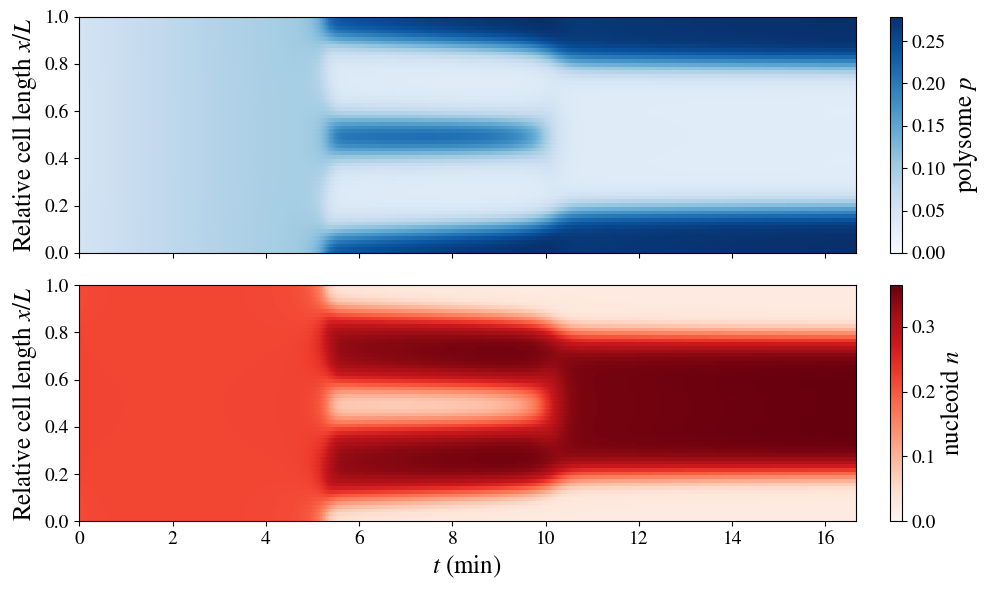

In [167]:
fig, ax = plot_kymograph(t_trace, phi_trace)
fig.savefig(output_prefix + "kymograph.pdf")

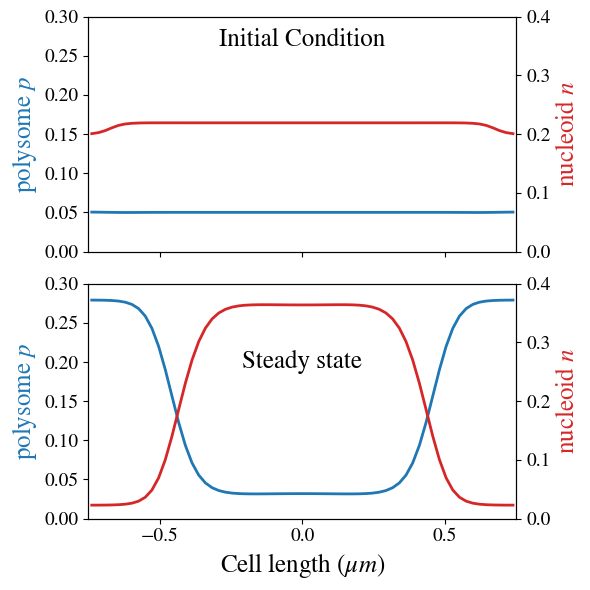

In [168]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), tight_layout=True, sharex=True)
ylims = [0.3, 0.4]

_ = plot_phi_absolute(
    phi_trace[0],
    params["l-init"],
    fig=fig,
    ax=(axs[0], axs[0].twinx()),
    ls="-",
    ylims=ylims,
)
axs[0].set_xlabel("")
_ = plot_phi_absolute(
    phi_trace[-1],
    params["l-init"],
    fig=fig,
    ax=(axs[1], axs[1].twinx()),
    ls="-",
    ylims=ylims,
)
axs[1].set_xticks([-0.5, 0, 0.5])

axs[0].text(
    0,
    0.27,
    "Initial Condition",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=18,
)
axs[1].text(
    0,
    0.2,
    "Steady state",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=18,
)
fig.savefig(output_prefix + "snaps_init_ss.pdf")

# Nucleoid segregation for growing cells

In [169]:
output_folder_growth = "data_growth"
os.system(f"mkdir -p {output_folder_growth}")

0

## Fit the relation between initial cell length and growth rate

In [170]:
data_length = onp.load("sander_initial_length.npz", allow_pickle=True)

data_growth_rate = data_length["growth_rate"]
data_initial_length = data_length["initial_length"]

<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_49576/1257833264.py:16: SyntaxWarning: invalid escape sequence '\g'
  label="fit: $l=l_0e^{\gamma/\gamma_0}$, "
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_49576/1257833264.py:18: SyntaxWarning: invalid escape sequence '\g'
  + "$\gamma_0={:.2f}$".format(1 / fitres_length_growth[0]),


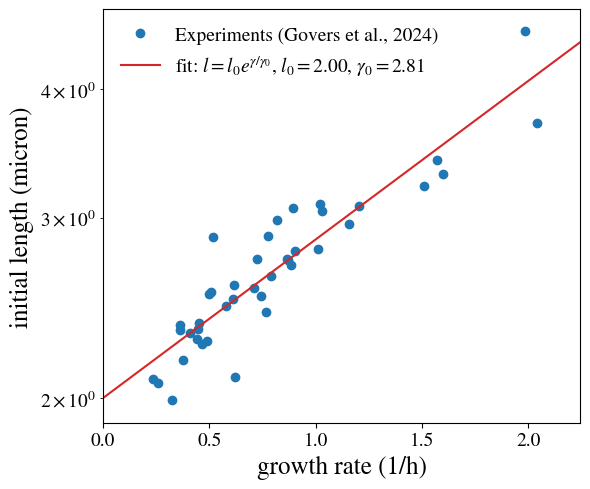

In [346]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.plot(
    data_growth_rate,
    data_initial_length,
    "o",
    color="tab:blue",
    label="Experiments (Govers et al., 2024)",
)
ax.set_yscale("log")
fitres_length_growth = onp.polyfit(data_growth_rate, onp.log(data_initial_length), 1)
gr_mesh = onp.linspace(0.0, data_growth_rate.max() * 1.1, 100)
ax.plot(
    gr_mesh,
    onp.exp(fitres_length_growth[1] + fitres_length_growth[0] * gr_mesh),
    color="tab:red",
    label="fit: $l=l_0e^{\gamma/\gamma_0}$, "
    + "$l_0 ={:.2f}$, ".format(onp.exp(fitres_length_growth[1]))
    + "$\gamma_0={:.2f}$".format(1 / fitres_length_growth[0]),
)

ax.set_xlabel("growth rate (1/h)")
ax.set_ylabel("initial length (micron)")
ax.set_xlim(gr_mesh[0], gr_mesh[-1])
ax.set_ylim(data_initial_length.min() * 0.95, data_initial_length.max() * 1.05)
ax.legend(frameon=False)
fig.savefig(output_folder_growth + "/length_vs_growth.pdf")

In [172]:
l_init_func = lambda gamma: onp.exp(
    fitres_length_growth[1] + fitres_length_growth[0] * gamma
)

## Run phase field simulations for a range of growth rates and nucleoid mobility

In [281]:
gamma_list = onp.linspace(0.25, 1.2, 10)[::-1]
T_list = onp.log(2) / gamma_list * 60 * 60
l_init_list = l_init_func(gamma_list)

gamma_seconds = gamma_list / 60 / 60
k1_list = k10 * (1 + gamma_seconds / kn1)

Dn_list = onp.array([5e-4, 1e-3, 5e-3])

In [282]:
def run_external_script(script_path, params):
    # Example: Running an external Python script
    command = ["python", script_path, *params.split()]
    subprocess.run(command, check=True)


def run_scripts_with_limit(script_path, script_params, max_workers):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for params in script_params:
            future = executor.submit(run_external_script, script_path, params)
            futures.append(future)

        # Use tqdm to create a progress bar
        with tqdm(total=len(script_params)) as pbar:
            for future in as_completed(futures):
                try:
                    future.result()  # Ensure any exceptions in the subprocess are propagated
                except Exception as e:
                    print(f"Subprocess error: {e}")
                pbar.update(1)  # Update progress bar for each completed task

In [283]:
filename_all = [
    [
        output_folder_growth
        + "/data/"
        + f"Dp_{flags.Dp}_Dn_{Dn}/"
        + f"scan_T_{T_list[T_id]/60:.0f}/"
        for T_id in range(len(T_list))
    ]
    for Dn in Dn_list
]

for Dn_id in range(len(Dn_list)):
    for T_id in range(len(T_list)):
        if os.path.exists(filename_all[Dn_id][T_id]):
            os.stat(filename_all[Dn_id][T_id])
        else:
            os.makedirs(filename_all[Dn_id][T_id])

default_parameters = {
    "L": flags.L,
    "N": flags.N,
    "kn1": flags.kn1,
    "chip": flags.chip,
    "chin": flags.chin,
    "chinp": flags.chinp,
    "Vn": flags.Vn,
    "Vp": flags.Vp,
    "lmda": flags.lmda,
    "Dp": flags.Dp,
    "phi-center-p": 0.02,
    "phi-boundary-n": 0.02,
    "phi-center-n": 0.6,
    "phi-boundary-p": 0.85,
    "l-center": 0.15,
}

default_parameters_str = " ".join(
    [f"--{key} {value}" for key, value in default_parameters.items()]
)

script_path = "polysome_phase_field.py"
script_params = [
    f"--T {T_list[T_id]} --l-init {l_init_list[T_id]} --gamma {gamma_list[T_id]} --Dn {Dn_list[Dn_id]} --filename {filename_all[Dn_id][T_id]} {default_parameters_str} --k1 {k1_list[T_id]}"
    for T_id in range(len(T_list))
    for Dn_id in range(len(Dn_list))
]

In [280]:
max_concurrent_processes = 16  # Adjust as needed
run_scripts_with_limit(script_path, script_params, max_concurrent_processes)

  0%|          | 0/20 [00:00<?, ?it/s]

Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth


 80%|████████  | 16/20 [02:02<00:08,  2.06s/it]

Simulate with growth
Simulate with growth
Simulate with growth
Simulate with growth


100%|██████████| 20/20 [03:07<00:00,  9.36s/it]


## Fig. 4B Visualize the dynamics of polysome and nucleoid during the cell cycle

In [284]:
gamma_id = -1
Dn_id = 1
# Dn_id = 0

print(f"gamma = {gamma_list[gamma_id]}", f"Dn = {Dn_list[Dn_id]}")
print(
    f"l_init = {l_init_list[gamma_id]:.1f} mu",
    f"l_final = {2*l_init_list[gamma_id]:.1f} mu",
)

gamma = 0.25 Dn = 0.001
l_init = 2.2 mu l_final = 4.4 mu


In [285]:
data = np.load(filename_all[Dn_id][gamma_id] + "phi_grow.npz")
t_trace = data["t_trace"]
phi_trace = data["phi_trace"]

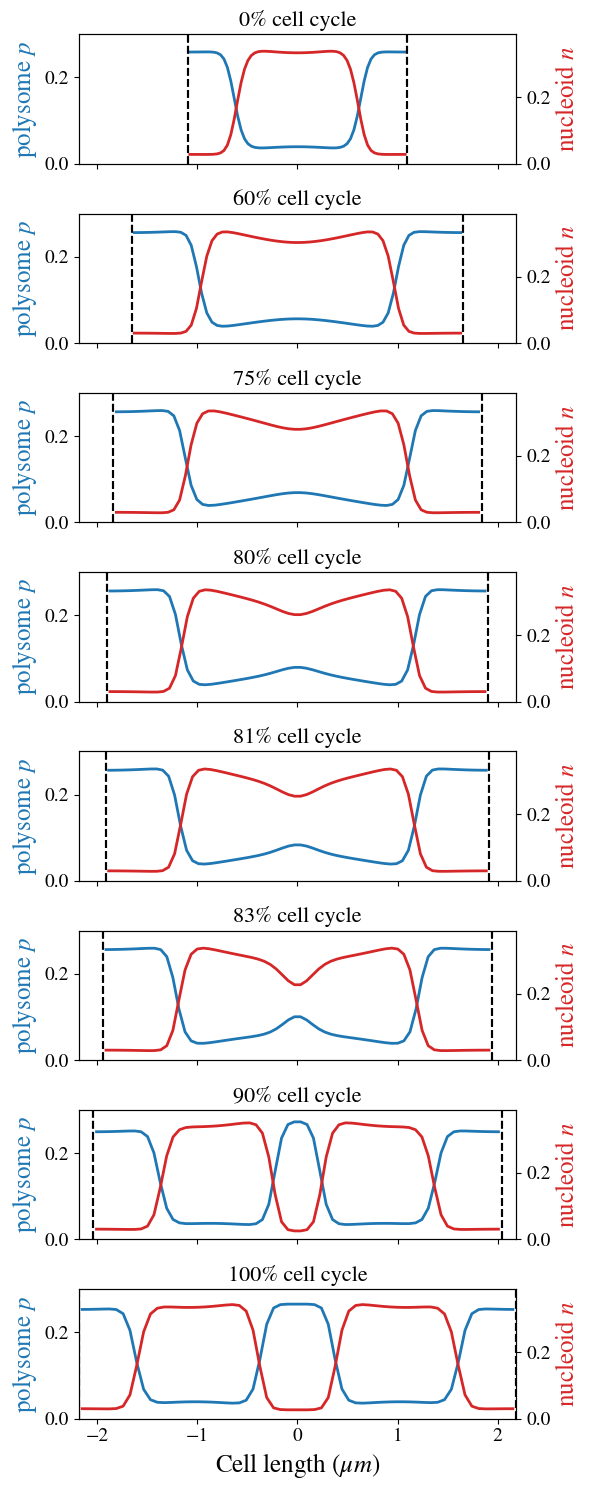

In [286]:
relative_cell_cycle_thresholds = onp.array([0, 0.6, 0.75, 0.8, 0.81, 0.83, 0.9, 1.0])
t_ids = onp.searchsorted(t_trace, t_trace[-1] * relative_cell_cycle_thresholds)
ylims = phi_trace.max(axis=(0, 2)) * 1.1
xlims = (-l_init_list[gamma_id], l_init_list[gamma_id])


# for plot_id in range(len(relative_cell_cycle_thresholds)):

fig, ax = plt.subplots(
    len(relative_cell_cycle_thresholds),
    1,
    figsize=(6, 15),
    tight_layout=True,
    sharex=True,
)
for plot_id in range(len(relative_cell_cycle_thresholds)):
    fig, ax_cur = plot_phi_absolute(
        phi_trace[t_ids[plot_id]],
        l_init_list[gamma_id]
        * np.exp(gamma_list[gamma_id] * t_trace[t_ids[plot_id]] / 60 / 60),
        xlims=xlims,
        ylims=ylims,
        fig=fig,
        ax=[ax[plot_id], ax[plot_id].twinx()],
    )
    ax_cur[0].set_title(
        f"{t_trace[t_ids[plot_id]]/T_list[gamma_id]*100:.0f}% cell cycle"
    )
    if plot_id < len(relative_cell_cycle_thresholds) - 1:
        ax_cur[0].set_xlabel("")
# fig.savefig(f"demo_snaps.pdf")

## Fig. 4D segregation time as a function of growth rate

In [287]:
data_constriction = onp.load("sander_constriction.npz", allow_pickle=True)

constriction_growth_rate = data_constriction["growth_rate"]
constriction_cell_length = data_constriction["constriction_length"]
constriction_relative_timing = data_constriction["constriction_relative_timing"]

In [288]:
Dn_id = 2

print(f"Dn = {Dn_list[Dn_id]}")

Dn = 0.005


In [289]:
segregation_threshold = 0.3

t_rel = onp.zeros(gamma_list.shape[0])
for gamma_id in range(gamma_list.shape[0]):
    data_init = np.load(filename_all[Dn_id][gamma_id] + "phi_init.npz")

    data = np.load(filename_all[Dn_id][gamma_id] + "phi_grow.npz")

    phi_init_ss = data_init["phi_trace"][-1]
    phi_init_ss = data["phi_trace"][0]
    n_threshold = (
        phi_init_ss[1].max()
        - (phi_init_ss[1].max() - phi_init_ss[1].min()) * segregation_threshold
    )
    n_center = data["phi_trace"][:, 1, flags.N // 4]
    # t_seg = onp.interp(-n_threshold, -n_center, data["t_trace"])
    l_seg = data["l_trace"][onp.argmin(onp.abs(n_center - n_threshold))]
    t_rel[gamma_id] = np.log(l_seg / l_init_list[gamma_id]) / np.log(2)

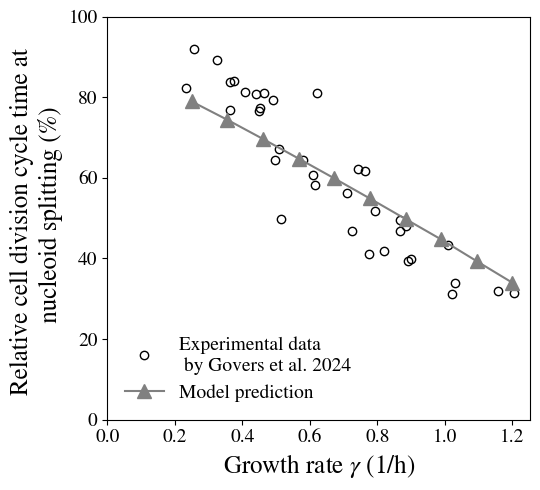

In [291]:
fig, ax = plt.subplots(figsize=(5.5, 5), tight_layout=True)

ax.plot(
    constriction_growth_rate,
    constriction_relative_timing * 100,
    "o",
    color="k",
    label="Experimental data \n by Govers et al. 2024",
    # plot empty circles for the experimental data
    mfc="none",
)

ax.plot(gamma_list, t_rel * 100, "-^", color="grey", ms=10, label="Model prediction")
ax.set_xlabel(r"Growth rate $\gamma$ (1/h)")
ax.set_ylabel("Relative cell division cycle time at \n nucleoid splitting (%)")
ax.legend(frameon=False)
ax.set_ylim(0, 100)
ax.set_xlim(0, None)
fig.savefig(output_folder_growth + "/seg_time_vs_growth.pdf")

## Fig. 4E Asymmetry for different nucleoid mobility coefficients

In [355]:
gamma_id = 6
print(f"gamma = {gamma_list[gamma_id]}")

gamma = 0.5666666666666667


In [356]:
phi_symmetric_all = []
phi_asymmetric_all = []
for Dn_id in range(len(Dn_list)):
    data = np.load(filename_all[Dn_id][gamma_id] + "phi_grow.npz")
    phi_symmetric_all.append(data["phi_trace"][0])
    phi_asymmetric_all.append(
        [np.interp(x_list, 2 * x_list, data["phi_trace"][-1][i]) for i in range(2)]
    )

phi_symmetric_all = np.array(phi_symmetric_all)
phi_asymmetric_all = np.array(phi_asymmetric_all)

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_49576/1752876437.py:23: SyntaxWarning: invalid escape sequence '\m'
  axs[0][len(Dn_list) - 1 - Dn_id].set_title(f"$D_n = {Dn_list[Dn_id]} \mu m^2/s$")
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_49576/1752876437.py:25: SyntaxWarning: invalid escape sequence '\m'
  axs[1][len(Dn_list) - 1 - Dn_id].set_xlabel("Cell length ($\mu m$)")


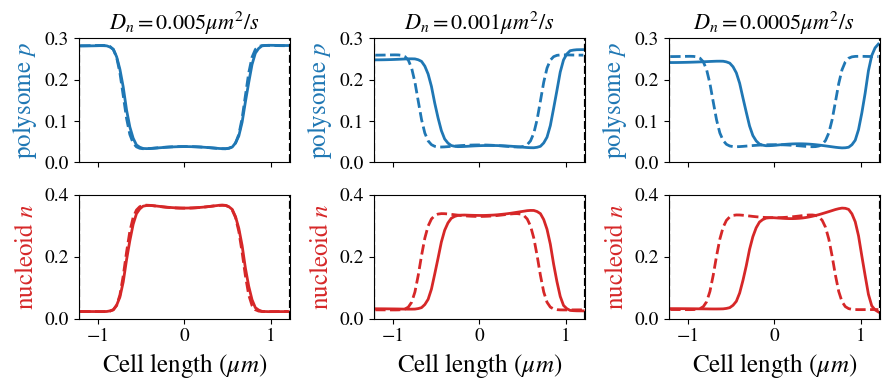

In [357]:
fig, axs = plt.subplots(2, 3, figsize=(9, 4), tight_layout=True, sharex=True)
xlims = (-l_init_list[gamma_id] / 2, l_init_list[gamma_id] / 2)
ylims = (0.3, 0.4)
for Dn_id in range(len(Dn_list)):
    plot_phi_absolute(
        phi_symmetric_all[Dn_id],
        l_init_list[gamma_id],
        xlims=xlims,
        ylims=ylims,
        fig=fig,
        ax=[axs[0][len(Dn_list) - 1 - Dn_id], axs[1][len(Dn_list) - 1 - Dn_id]],
        ls="--",
    )
    plot_phi_absolute(
        phi_asymmetric_all[Dn_id],
        l_init_list[gamma_id],
        xlims=xlims,
        ylims=ylims,
        fig=fig,
        ax=[axs[0][len(Dn_list) - 1 - Dn_id], axs[1][len(Dn_list) - 1 - Dn_id]],
        ls="-",
    )
    axs[0][len(Dn_list) - 1 - Dn_id].set_title(f"$D_n = {Dn_list[Dn_id]} \mu m^2/s$")
    axs[0][len(Dn_list) - 1 - Dn_id].set_xlabel("")
    axs[1][len(Dn_list) - 1 - Dn_id].set_xlabel("Cell length ($\mu m$)")
fig.savefig(output_folder_growth + f"/asymmetry_vs_Dn.pdf")

## Fig. 4 Supplement 2: cell length vs growth rate

<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_49576/897234085.py:16: SyntaxWarning: invalid escape sequence '\g'
  label="fit: $l=l_0e^{\gamma/\gamma_0}$, "
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_49576/897234085.py:18: SyntaxWarning: invalid escape sequence '\g'
  + "$\gamma_0={:.2f}$".format(1 / fitres_length_growth[0]),


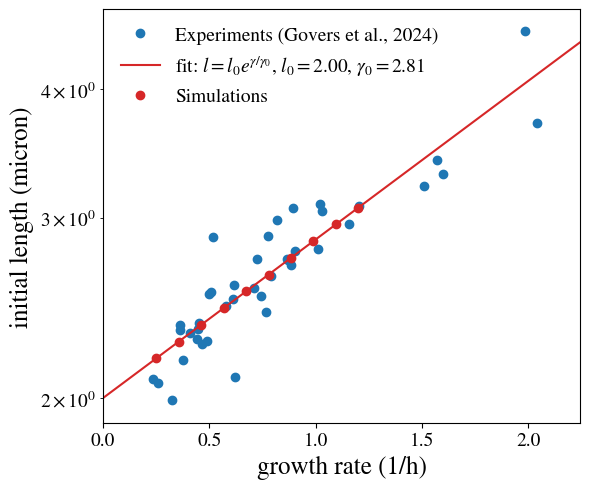

In [358]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.plot(
    data_growth_rate,
    data_initial_length,
    "o",
    color="tab:blue",
    label="Experiments (Govers et al., 2024)",
)
ax.set_yscale("log")
fitres_length_growth = onp.polyfit(data_growth_rate, onp.log(data_initial_length), 1)
gr_mesh = onp.linspace(0.0, data_growth_rate.max() * 1.1, 100)
ax.plot(
    gr_mesh,
    onp.exp(fitres_length_growth[1] + fitres_length_growth[0] * gr_mesh),
    color="tab:red",
    label="fit: $l=l_0e^{\gamma/\gamma_0}$, "
    + "$l_0 ={:.2f}$, ".format(onp.exp(fitres_length_growth[1]))
    + "$\gamma_0={:.2f}$".format(1 / fitres_length_growth[0]),
)
ax.plot(gamma_list, l_init_list, "o", color="tab:red", label="Simulations")
ax.set_xlabel("growth rate (1/h)")
ax.set_ylabel("initial length (micron)")
ax.set_xlim(gr_mesh[0], gr_mesh[-1])
ax.set_ylim(data_initial_length.min() * 0.95, data_initial_length.max() * 1.05)
ax.legend(frameon=False)
fig.savefig(output_folder_growth + "/length_vs_growth.pdf")

## Fig. 4 Supplement 3: cell length at nucleoid segregation

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6x/lcn6tbp51p7d0b4jzf4jkx3w0000gn/T/ipykernel_49576/3427655220.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("Cell length at nucleoid splitting ($\mu m$)")


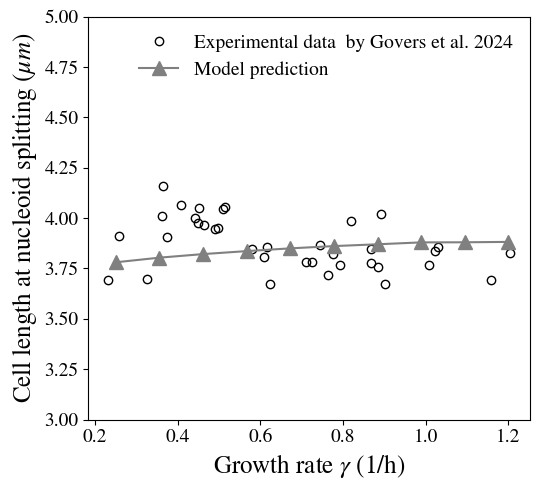

In [359]:
fig, ax = plt.subplots(figsize=(5.5, 5), tight_layout=True)

ax.plot(
    constriction_growth_rate,
    constriction_cell_length,
    "o",
    color="k",
    label="Experimental data  by Govers et al. 2024",
    # plot empty circles for the experimental data
    mfc="none",
)

ax.plot(
    gamma_list,
    l_init_list * np.exp(np.log(2) * t_rel),
    "-^",
    color="grey",
    ms=10,
    label="Model prediction",
)
ax.set_xlabel(r"Growth rate $\gamma$ (1/h)")
ax.set_ylabel("Cell length at nucleoid splitting ($\mu m$)")
ax.legend(frameon=False)
ax.set_ylim(3, 5)
fig.savefig(output_folder_growth + "/seg_length_vs_growth.pdf")